In [2]:
import os

# Подивимось на структуру папок датасету
data_path = "/kaggle/input"

for dirname, _, filenames in os.walk(data_path):
    # Показуємо тільки назви папок (класи), не всі файли
    level = dirname.replace(data_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(dirname)}/')
    if level >= 2:  # не заглиблюємось далі 2 рівнів
        continue

input/
  datasets/
    sshikamaru/
      fruit-recognition/
        test/
          test/
        train/
          train/
            Orange/
            Tomato/
            Passion Fruit/
            Cucumber Ripe/
            Cactus fruit/
            Pomegranate/
            Plum/
            Pineapple/
            Papaya/
            Potato Red/
            Kiwi/
            Limes/
            Apple Braeburn/
            Pear/
            Onion White/
            Strawberry/
            Grape Blue/
            Blueberry/
            Apple Granny Smith/
            Apricot/
            Pepper Red/
            Clementine/
            Lemon/
            Avocado/
            Raspberry/
            Cantaloupe/
            Peach/
            Corn/
            Banana/
            Cherry/
            Pepper Green/
            Watermelon/
            Mango/


In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch.nn as nn

# Трансформації для тренувальних даних (з аугментацією)
# Посилання: https://pytorch.org/vision/stable/transforms.html
# Навіщо це потрібно: нейромережа вчиться краще, коли бачить більше різноманітних прикладів.
# Без аугментації вона може "завчити" конкретні фото замість того,
# щоб зрозуміти загальні ознаки фрукта.
# Аугментація — це коли ти штучно "розмножуєш" свої фотографії, трохи змінюючи кожну.
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Шлях до даних (тільки train — там є підпапки з класами)
train_path = "/kaggle/input/datasets/sshikamaru/fruit-recognition/train/train/"

# GPU пристрій
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Пристрій: {device}")

Пристрій: cuda


In [7]:
# Розбиття (як на уроці)
# Повний датасет з двома варіантами трансформацій
full_dataset = datasets.ImageFolder(train_path, transform=train_transform)
full_dataset_test = datasets.ImageFolder(train_path, transform=test_transform)

# Фіксуємо seed для однакового розбиття (однаково для PyTorch і TensorFlow!)
torch.manual_seed(42)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

# Генеруємо індекси один раз для усіх 4 варіантів
indices = torch.randperm(len(full_dataset)).tolist()
train_indices = indices[:train_size]
test_indices = indices[train_size:]

# Train — з аугментацією, Test — без аугментації
train_dataset = Subset(full_dataset, train_indices)
test_dataset = Subset(full_dataset_test, test_indices)

# DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Параметри
input_size = 3 * 224 * 224  # 150528
num_classes = len(full_dataset.classes)

print(f"Тренувальних: {len(train_dataset)}")
print(f"Тестових: {len(test_dataset)}")

# Назви класів (фруктів)
print(f"Кількість класів: {len(full_dataset.classes)}")
print(f"Класи: {full_dataset.classes}")
print(f"\nclass_to_idx: {full_dataset.class_to_idx}")

print(f"Розмір входу: {input_size}")

Тренувальних: 13483
Тестових: 3371
Кількість класів: 33
Класи: ['Apple Braeburn', 'Apple Granny Smith', 'Apricot', 'Avocado', 'Banana', 'Blueberry', 'Cactus fruit', 'Cantaloupe', 'Cherry', 'Clementine', 'Corn', 'Cucumber Ripe', 'Grape Blue', 'Kiwi', 'Lemon', 'Limes', 'Mango', 'Onion White', 'Orange', 'Papaya', 'Passion Fruit', 'Peach', 'Pear', 'Pepper Green', 'Pepper Red', 'Pineapple', 'Plum', 'Pomegranate', 'Potato Red', 'Raspberry', 'Strawberry', 'Tomato', 'Watermelon']

class_to_idx: {'Apple Braeburn': 0, 'Apple Granny Smith': 1, 'Apricot': 2, 'Avocado': 3, 'Banana': 4, 'Blueberry': 5, 'Cactus fruit': 6, 'Cantaloupe': 7, 'Cherry': 8, 'Clementine': 9, 'Corn': 10, 'Cucumber Ripe': 11, 'Grape Blue': 12, 'Kiwi': 13, 'Lemon': 14, 'Limes': 15, 'Mango': 16, 'Onion White': 17, 'Orange': 18, 'Papaya': 19, 'Passion Fruit': 20, 'Peach': 21, 'Pear': 22, 'Pepper Green': 23, 'Pepper Red': 24, 'Pineapple': 25, 'Plum': 26, 'Pomegranate': 27, 'Potato Red': 28, 'Raspberry': 29, 'Strawberry': 30, 'Tom

In [9]:
# Подивимось на перший зразок
img, label = full_dataset[0]
print(f"Тип: {type(img)}")
print(f"Форма тензора: {img.shape}")  # [C, H, W] = [3, 224, 224]
print(f"Мітка (індекс): {label}")
print(f"Назва класу: {full_dataset.classes[label]}")

# Перший зразок з кожного класу (до 5 класів)
shown_classes = set()
for i in range(len(full_dataset)):
    img, label = full_dataset[i]
    if label not in shown_classes:
        print(f"Зразок [{i}]: форма {img.shape}, мітка: {label} → {full_dataset.classes[label]}")
        shown_classes.add(label)
    if len(shown_classes) >= 5:
        break

Тип: <class 'torch.Tensor'>
Форма тензора: torch.Size([3, 224, 224])
Мітка (індекс): 0
Назва класу: Apple Braeburn
Зразок [0]: форма torch.Size([3, 224, 224]), мітка: 0 → Apple Braeburn
Зразок [492]: форма torch.Size([3, 224, 224]), мітка: 1 → Apple Granny Smith
Зразок [984]: форма torch.Size([3, 224, 224]), мітка: 2 → Apricot
Зразок [1476]: форма torch.Size([3, 224, 224]), мітка: 3 → Avocado
Зразок [1903]: форма torch.Size([3, 224, 224]), мітка: 4 → Banana


In [10]:

# Візуалізація - Перевірка
for images, labels in train_loader:
    print(f"Форма батчу зображень: {images.shape}")  # [batch_size, 3, 224, 224]
    print(f"Форма батчу міток: {labels.shape}")       # [batch_size]
    break  # Виводимо тільки перший батч

Форма батчу зображень: torch.Size([32, 3, 224, 224])
Форма батчу міток: torch.Size([32])


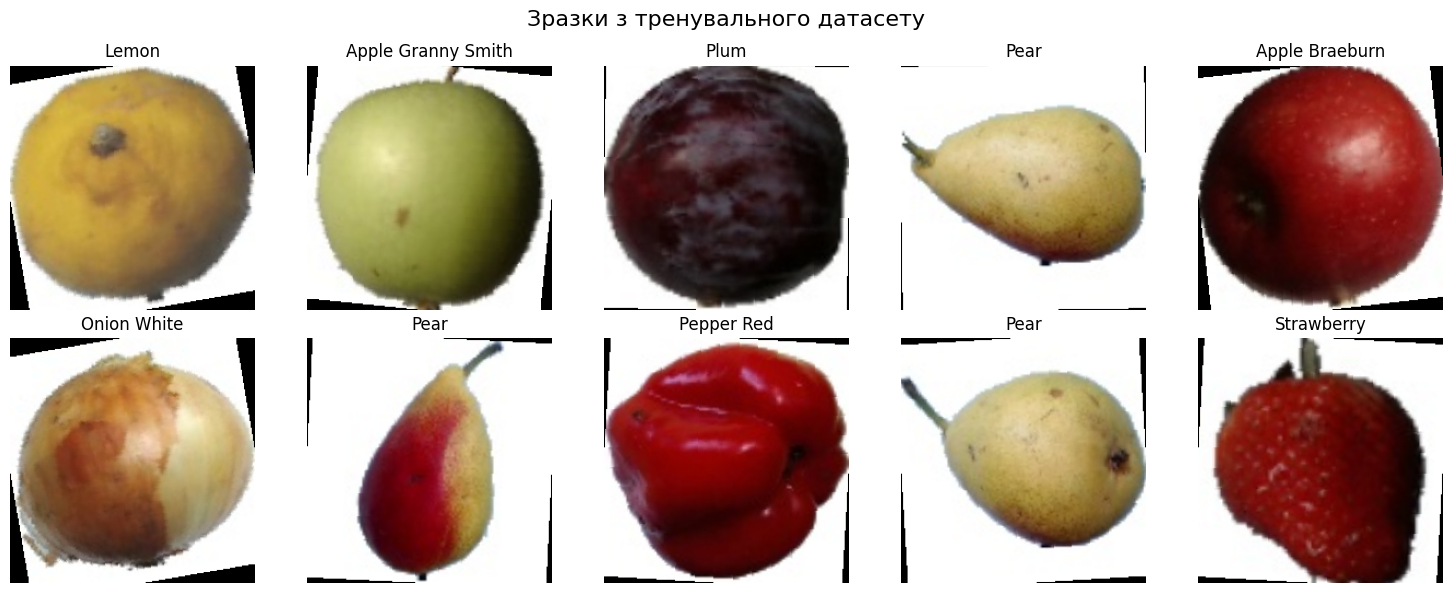

In [12]:
# Візуалізація кількох зразків з тренувального набору
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    img, label = train_dataset[i]
    # Конвертуємо тензор [C, H, W] → [H, W, C] для matplotlib
    img_np = img.permute(1, 2, 0).numpy()
    ax.imshow(img_np)
    ax.set_title(full_dataset.classes[label])
    ax.axis('off')

plt.suptitle("Зразки з тренувального датасету", fontsize=16)
plt.tight_layout()
plt.show()

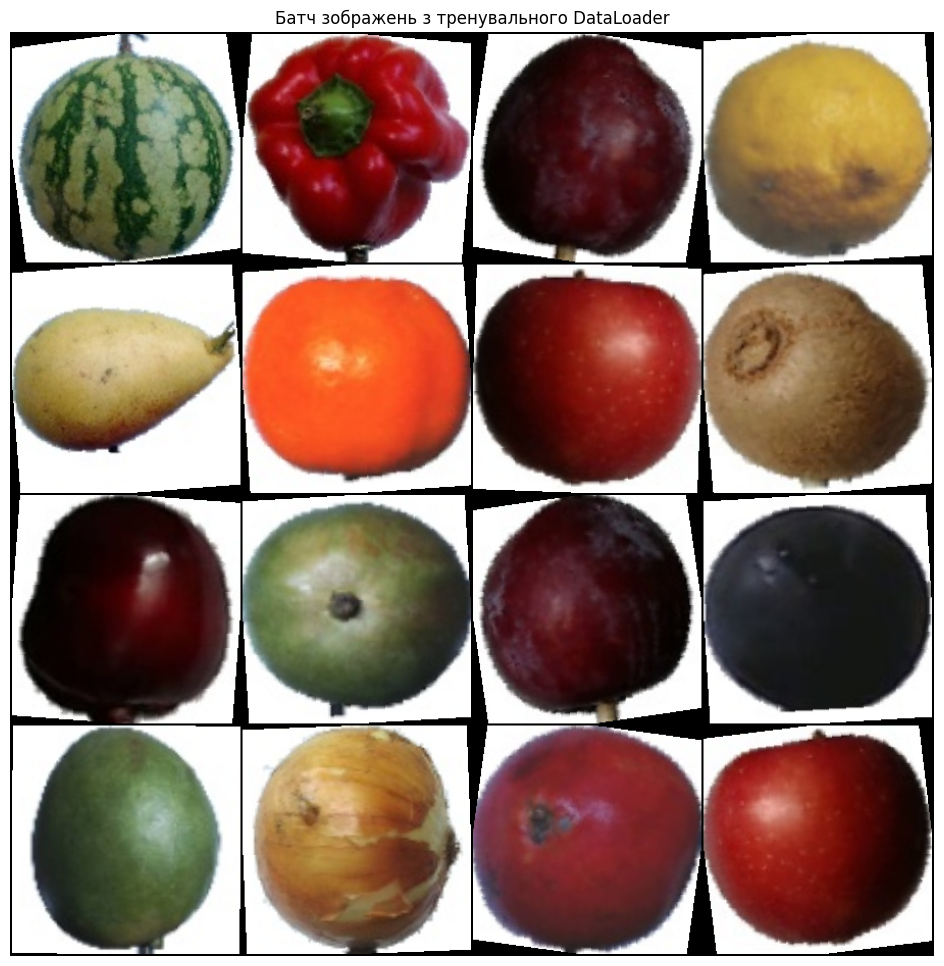

Мітки: ['Watermelon', 'Pepper Red', 'Plum', 'Lemon', 'Pear', 'Clementine', 'Apple Braeburn', 'Kiwi', 'Cherry', 'Mango', 'Plum', 'Grape Blue', 'Mango', 'Onion White', 'Pomegranate', 'Apple Braeburn']


In [13]:
# Отримуємо один батч
images, labels = next(iter(train_loader))

# Створюємо сітку зображень
grid = make_grid(images[:16], nrow=4, padding=2)

# Відображаємо
plt.figure(figsize=(12, 12))
plt.imshow(grid.permute(1, 2, 0).numpy())
plt.title("Батч зображень з тренувального DataLoader")
plt.axis('off')
plt.show()

# Виводимо мітки
print("Мітки:", [full_dataset.classes[l] for l in labels[:16].tolist()])

In [14]:
# Fruit Classification — 4 варіанти нейромережі

# Вхід:       3 × 224 × 224 = 150528
# Flatten:    [batch, 150528]
# Linear/Dense 1:  150528 → 512  + activation
# Linear/Dense 2:  512 → 256     + activation
# Linear/Dense 3:  256 → 128     + activation
# Linear/Dense 4:  128 → num_classes (вихід)

# Параметри
input_size = 3 * 224 * 224  # 150528
num_classes = len(full_dataset.classes)

print(f"Тренувальних: {len(train_dataset)}")
print(f"Тестових: {len(test_dataset)}")

# Назви класів (фруктів)
print(f"Кількість класів: {len(full_dataset.classes)}")
print(f"Класи: {full_dataset.classes}")
print(f"\nclass_to_idx: {full_dataset.class_to_idx}")

print(f"Розмір входу: {input_size}")

Тренувальних: 13483
Тестових: 3371
Кількість класів: 33
Класи: ['Apple Braeburn', 'Apple Granny Smith', 'Apricot', 'Avocado', 'Banana', 'Blueberry', 'Cactus fruit', 'Cantaloupe', 'Cherry', 'Clementine', 'Corn', 'Cucumber Ripe', 'Grape Blue', 'Kiwi', 'Lemon', 'Limes', 'Mango', 'Onion White', 'Orange', 'Papaya', 'Passion Fruit', 'Peach', 'Pear', 'Pepper Green', 'Pepper Red', 'Pineapple', 'Plum', 'Pomegranate', 'Potato Red', 'Raspberry', 'Strawberry', 'Tomato', 'Watermelon']

class_to_idx: {'Apple Braeburn': 0, 'Apple Granny Smith': 1, 'Apricot': 2, 'Avocado': 3, 'Banana': 4, 'Blueberry': 5, 'Cactus fruit': 6, 'Cantaloupe': 7, 'Cherry': 8, 'Clementine': 9, 'Corn': 10, 'Cucumber Ripe': 11, 'Grape Blue': 12, 'Kiwi': 13, 'Lemon': 14, 'Limes': 15, 'Mango': 16, 'Onion White': 17, 'Orange': 18, 'Papaya': 19, 'Passion Fruit': 20, 'Peach': 21, 'Pear': 22, 'Pepper Green': 23, 'Pepper Red': 24, 'Pineapple': 25, 'Plum': 26, 'Pomegranate': 27, 'Potato Red': 28, 'Raspberry': 29, 'Strawberry': 30, 'Tom

In [15]:
 # Варіант 1: PyTorch + ReLU

class FruitNet_ReLU(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),                         # Шар 1: → [batch, 150528]
            nn.Linear(input_size, 512),            # Шар 2: 150528 → 512
            nn.ReLU(),
            nn.Linear(512, 256),                   # Шар 3: 512 → 256
            nn.ReLU(),
            nn.Linear(256, 128),                   # Шар 4: 256 → 128
            nn.ReLU(),
            nn.Linear(128, num_classes),            # Шар 5: 128 → num_classes
        )

    def forward(self, x):
        return self.model(x)

model_relu = FruitNet_ReLU(input_size, num_classes).to(device)
print("=== PyTorch + ReLU ===")
print(model_relu)

=== PyTorch + ReLU ===
FruitNet_ReLU(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=150528, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): ReLU()
    (7): Linear(in_features=128, out_features=33, bias=True)
  )
)


In [16]:
 # Варіант 2: PyTorch + LeakyReLU

class FruitNet_LeakyReLU(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),                         # Шар 1: → [batch, 150528]
            nn.Linear(input_size, 512),            # Шар 2: 150528 → 512
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(512, 256),                   # Шар 3: 512 → 256
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(256, 128),                   # Шар 4: 256 → 128
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(128, num_classes),            # Шар 5: 128 → num_classes
        )

    def forward(self, x):
        return self.model(x)

model_leaky = FruitNet_LeakyReLU(input_size, num_classes).to(device)

print("=== PyTorch + LeakyReLU ===")
print(model_leaky)

=== PyTorch + LeakyReLU ===
FruitNet_LeakyReLU(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=150528, out_features=512, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Linear(in_features=128, out_features=33, bias=True)
  )
)


In [17]:
# Перевірка обох моделей PyTorch

# тут потрібен .to(device)
images, labels = next(iter(train_loader))
images = images.to(device)          # ← бо модель на GPU

output_relu = model_relu(images)     # модель на GPU, дані теж на GPU
output_leaky = model_leaky(images)

print(f"Вхід:             {images.shape}")
print(f"Вихід ReLU:       {output_relu.shape}")
print(f"Вихід LeakyReLU:  {output_leaky.shape}")

# Кількість параметрів
def count_params(model):
    return sum(p.numel() for p in model.parameters())

print(f"\nПараметрів ReLU:      {count_params(model_relu):,}")
print(f"Параметрів LeakyReLU: {count_params(model_leaky):,}")

Вхід:             torch.Size([32, 3, 224, 224])
Вихід ReLU:       torch.Size([32, 33])
Вихід LeakyReLU:  torch.Size([32, 33])

Параметрів ReLU:      77,239,329
Параметрів LeakyReLU: 77,239,329


In [ ]:

# TensorFlow / Keras
# Імпорт та дані (TensorFlow)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

train_tf = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int',
)
test_tf = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int',
)

# Зберігаємо class_names ДО map
class_names_tf = train_tf.class_names
num_classes_tf = len(class_names_tf)

# Нормалізація
normalization = layers.Rescaling(1./255)
train_tf = train_tf.map(lambda x, y: (normalization(x), y))
test_tf = test_tf.map(lambda x, y: (normalization(x), y))

# Параметри
input_shape = (224, 224, 3)
print(f"Класи: {class_names_tf}")
print(f"Кількість класів: {num_classes_tf}")

In [ ]:
# Варіант 3: TensorFlow + ReLU
# model_tf_relu = keras.Sequential([
#     layers.Flatten(input_shape=input_shape, name='flatten'),      # Шар 1
#     layers.Dense(512, activation='relu', name='dense_1'),          # Шар 2: 150528 → 512
#     layers.Dense(256, activation='relu', name='dense_2'),          # Шар 3: 512 → 256
#     layers.Dense(128, activation='relu', name='dense_3'),          # Шар 4: 256 → 128
#     layers.Dense(num_classes, activation='softmax', name='output') # Шар 5: 128 → num_classes
# ], name='FruitNet_ReLU')

model_tf_relu = keras.Sequential([
    layers.Input(shape=input_shape),                               # ← новий спосіб
    layers.Flatten(name='flatten'),                                # без input_shape
    layers.Dense(512, activation='relu', name='dense_1'),
    layers.Dense(256, activation='relu', name='dense_2'),
    layers.Dense(128, activation='relu', name='dense_3'),
    layers.Dense(num_classes_tf, activation='softmax', name='output')
], name='FruitNet_ReLU')

model_tf_relu.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("=== TensorFlow + ReLU ===")
model_tf_relu.summary()

In [ ]:
# Варіант 4: TensorFlow + LeakyReLU
# # Старий спосіб:
# model_tf_leaky = keras.Sequential([
#     layers.Flatten(input_shape=input_shape, name='flatten'),
#     layers.Dense(512, name='dense_1'),
#     layers.LeakyReLU(negative_slope=0.01, name='leaky_1'),
#     ...
# ], name='FruitNet_LeakyReLU')

# Новий спосіб:
model_tf_leaky = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.Flatten(name='flatten'),
    layers.Dense(512, name='dense_1'),
    layers.LeakyReLU(negative_slope=0.01, name='leaky_1'),
    layers.Dense(256, name='dense_2'),
    layers.LeakyReLU(negative_slope=0.01, name='leaky_2'),
    layers.Dense(128, name='dense_3'),
    layers.LeakyReLU(negative_slope=0.01, name='leaky_3'),
    layers.Dense(num_classes_tf, activation='softmax', name='output'),
], name='FruitNet_LeakyReLU')

model_tf_leaky.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("=== TensorFlow + LeakyReLU ===")
model_tf_leaky.summary()

In [ ]:
 # Перевірка обох моделей TensorFlow

for images, labels in train_tf.take(1):
    output_relu = model_tf_relu(images)
    output_leaky = model_tf_leaky(images)

    print(f"Вхід:             {images.shape}")
    print(f"Вихід ReLU:       {output_relu.shape}")
    print(f"Вихід LeakyReLU:  {output_leaky.shape}")

print(f"\nПараметрів ReLU:      {model_tf_relu.count_params():,}")
print(f"Параметрів LeakyReLU: {model_tf_leaky.count_params():,}")